# Time Series with XGBoost - COVID

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Import Data

In [2]:
with open('covid_data.p', 'rb') as f:
    data = pickle.load(f)

In [3]:
# Basic data cleanup
data = data[data.fips_code == '36047']
data = data.set_index('date')

data = data[['deaths_cdc','confirmed_cdc']]
data['daily_deaths'] = data.deaths_cdc.diff()
data['3_day_ave'] =  data.daily_deaths.rolling(window=3).mean()
data['5_day_ave'] =  data.daily_deaths.rolling(window=5).mean()
data['7_day_ave'] =  data.daily_deaths.rolling(window=7).mean()
data['14_day_ave'] =  data.daily_deaths.rolling(window=14).mean()

data['daily_cases'] = data.confirmed_cdc.diff()
data['3_day_case_ave'] =  data.daily_cases.rolling(window=3).mean()
data['5_day_case_ave'] =  data.daily_cases.rolling(window=5).mean()
data['7_day_case_ave'] =  data.daily_cases.rolling(window=7).mean()
data['14_day_case_ave'] =  data.daily_cases.rolling(window=14).mean()

data.sort_index(inplace=True)
data = data.dropna()
data.tail()

#For debugging
df = pd.DataFrame(data)

## Split the data

In [4]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

In [5]:
train, test = split_data(data, '01-Oct-2020')

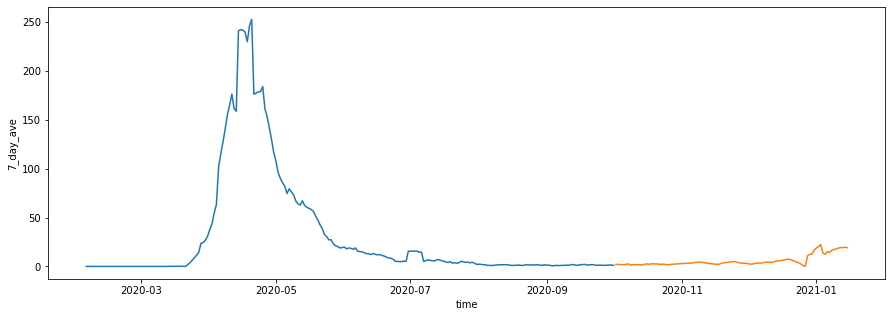

In [6]:
# Plot the train & test data
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('7_day_ave')
plt.plot(train.index,train["7_day_ave"])
plt.plot(test.index,test["7_day_ave"])
plt.show()

## Feature Engineering

In [7]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','3_day_ave', '5_day_ave',
            #'7_day_ave',
            '14_day_ave','deaths_cdc', 
            'confirmed_cdc','3_day_case_ave', '5_day_case_ave','7_day_case_ave','14_day_case_ave',
            'daily_deaths'
           ]]
    return X

In [8]:
X_train, y_train = create_features(train), train['7_day_ave']
X_test, y_test   = create_features(test), test['7_day_ave'] 

X_train.shape, y_train.shape

/home/james/.conda/envs/moby/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


((240, 18), (240,))

In [9]:
X_train.tail(3)

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,3_day_ave,5_day_ave,14_day_ave,deaths_cdc,confirmed_cdc,3_day_case_ave,5_day_case_ave,7_day_case_ave,14_day_case_ave,daily_deaths
date,,,,,,,,,,,,,,,,,,
2020-09-29,0,1,3,9,2020,273,29,40,2.000000,1.6,1.642857,7329.0,68658.0,187.666667,188.2,181.000000,162.642857,2.0
2020-09-30,0,2,3,9,2020,274,30,40,1.000000,1.2,1.285714,7329.0,68844.0,188.333333,190.4,190.571429,169.714286,0.0
2020-10-01,0,3,4,10,2020,275,1,40,0.666667,1.2,1.214286,7329.0,69062.0,200.000000,193.4,192.142857,176.857143,0.0


## Train the Model

In [10]:
reg = xgb.XGBRegressor(
    n_estimators=10000,
    learning_rate=0.01,
    max_depth=6
)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=10)

[0]	validation_0-rmse:63.65401	validation_1-rmse:7.46562
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:58.10861	validation_1-rmse:6.80421
[20]	validation_0-rmse:53.07893	validation_1-rmse:6.24549
[30]	validation_0-rmse:48.50794	validation_1-rmse:5.75948
[40]	validation_0-rmse:44.35133	validation_1-rmse:5.32158
[50]	validation_0-rmse:40.56457	validation_1-rmse:4.92173
[60]	validation_0-rmse:37.11388	validation_1-rmse:4.58689
[70]	validation_0-rmse:33.97374	validation_1-rmse:4.29398
[80]	validation_0-rmse:31.10914	validation_1-rmse:4.03271
[90]	validation_0-rmse:28.49410	validation_1-rmse:3.81221
[100]	validation_0-rmse:26.10173	validation_1-rmse:3.61843
[110]	validation_0-rmse:23.91509	validation_1-rmse:3.43769
[120]	validation_0-rmse:21.91600	validation_1-rmse:3.28854
[130]	validation_0-rmse:20.08916	validation_1-rmse:3.14108
[140]	validation_0-rmse:18

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Performance Metrics

In [11]:
X_test_pred = reg.predict(X_test)

In [12]:
# Mean Squared Error
mean_squared_error(y_true=y_test,
                   y_pred=X_test_pred)

3.384845106518094

In [13]:
# Mean Absolute Error
mean_absolute_error(y_true=y_test,
                   y_pred=X_test_pred)


1.11412562000141

## Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

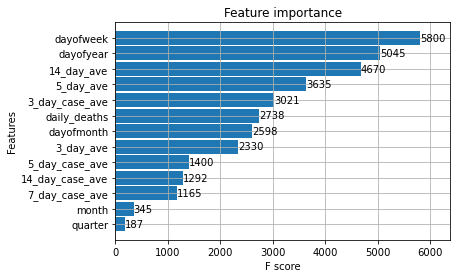

In [14]:
xgb.plot_importance(reg, height=0.9)

## Forecast on Test Data

In [15]:
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('time')
    plt.ylabel('energy consumed')
    plt.plot(base_data.index, base_data, label='data')
    plt.plot(X_test.index, X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)
    #print(base_data["daily_deaths"])

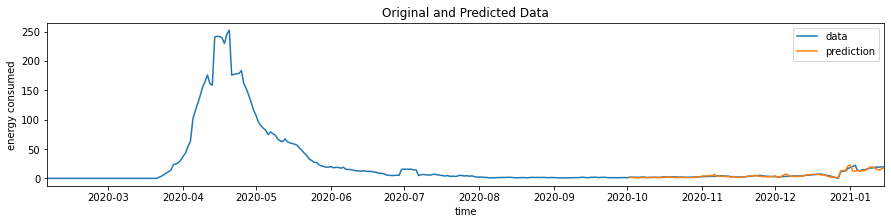

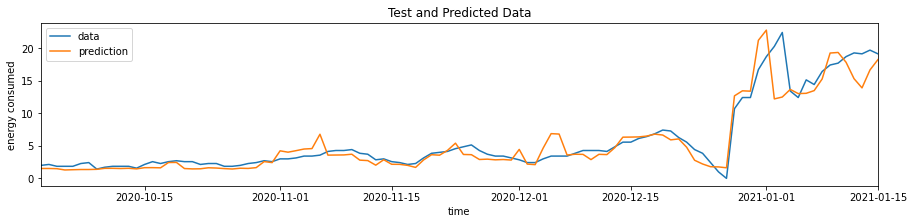

In [16]:
plot_performance(
    df["7_day_ave"], 
    df.index[0].date(), 
    df.index[-1].date(),
    'Original and Predicted Data'
)

plot_performance(
    y_test, y_test.index[0].date(), 
    y_test.index[-1].date(),
    'Test and Predicted Data')

plt.legend()
plt.show()

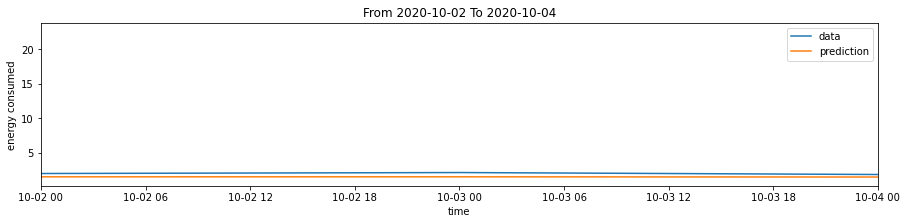

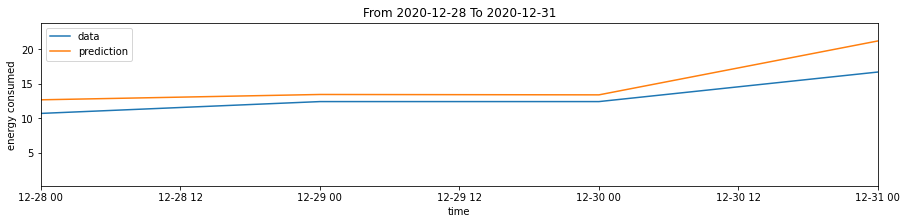

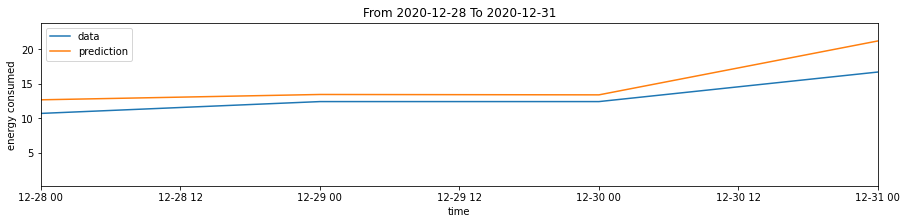

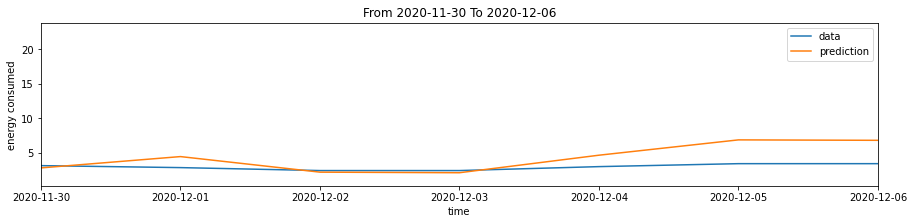

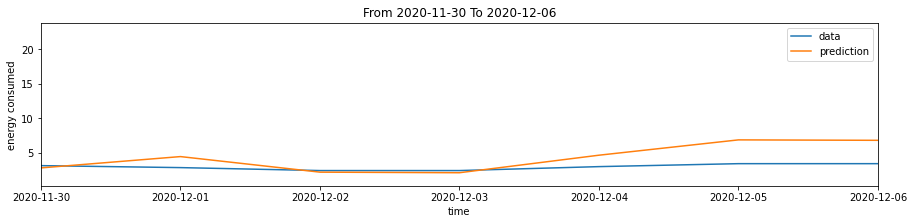

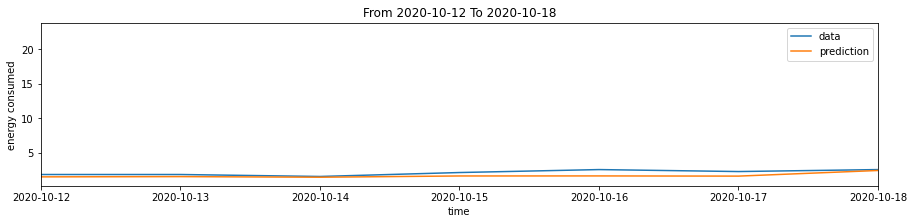

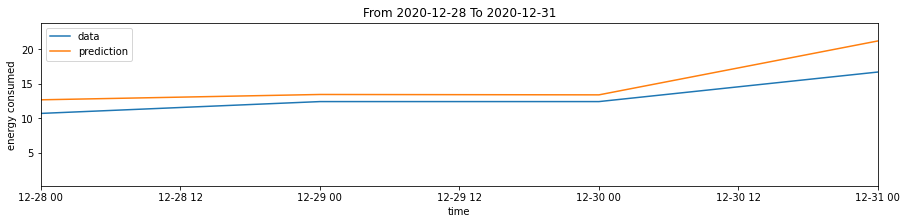

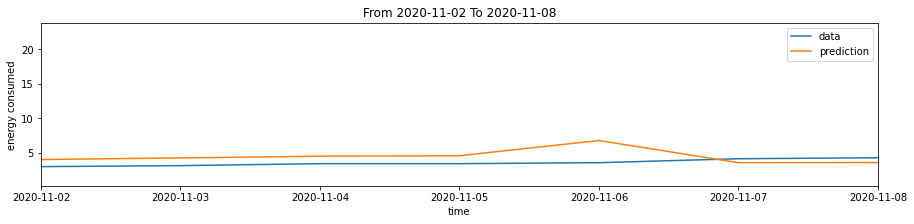

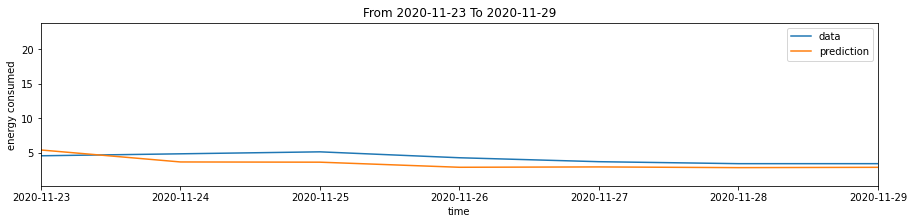

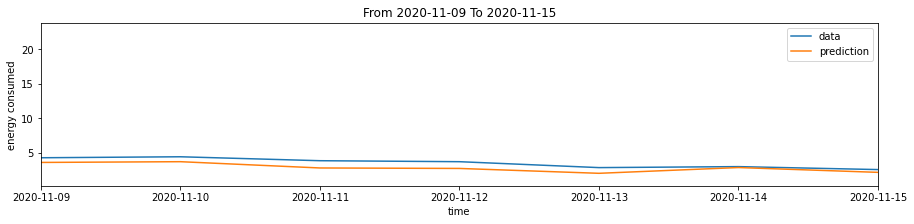

In [17]:
# Peformance for 10 random weeks 
random_weeks = X_test[['year', 'weekofyear']].sample(10)
for week in random_weeks.iterrows():
    index = (X_test.year == week[1].year) & \
            (X_test.weekofyear == week[1].weekofyear)
    data = y_test[index]
    plot_performance(data, data.index[0].date(), data.index[-1].date())